In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

**Does competing sites ever lead to bad signal?**

Let's re-do the case study on simple repression by lacI. This time, instead of placing the lacI binding site downstream of the RNAP binding site, we place the lacI binding site at the -10 binding site of RNAP

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [4]:
## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

#rep_emat = rnap_emat[(len(rnap_site) - len(original_rep_site)):(len(rnap_site))]

In [6]:
original_rep_site = 'AATTGTGAGCGGATAACAATT'
print('The length of the original repressor binding site is {}.'.format(len(original_rep_site)))

The length of the original repressor binding site is 21.


In [7]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], original_rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Assuming the the repressor has the same energy matrix has the RNAP

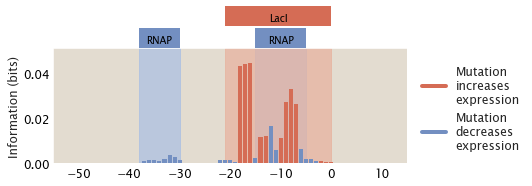

In [8]:
# Alternative repressor binding site
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):(len(rnap_site))]

O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-21, 0, 'R', 'LacI', True)]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-55, 15), fig_width=8, fig_height=3,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/overlapping1.png')

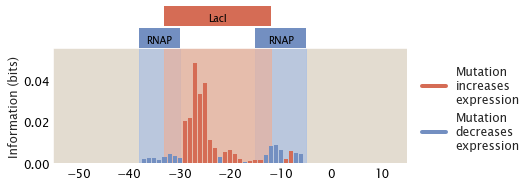

In [9]:
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site) - 12):(len(rnap_site) - 12)]

O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-33, -12, 'R', 'LacI', True)]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-55, 15), fig_width=8, fig_height=3,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/overlapping2.png')

### Repressor binding site overlapping with activator binding site

In [10]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [11]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

In [12]:
promoter.find(crp_site)

41

In [13]:
rep_site = promoter[51:(51+21)]

O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

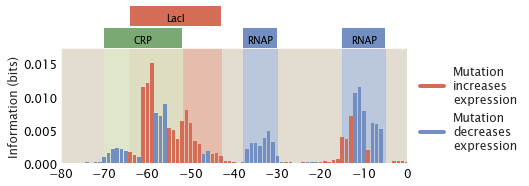

In [15]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -13, -10
e_int = -13
n_p, n_r, n_a = 4600, 50, 50

df = tregs.simulate.sim(promoter, tregs.simulate.repact_pbound, [rnap_site, rep_site, crp_site],
                        *[n_NS, n_p, n_r, n_a, rnap_emat, rep_emat, crp_emat, ep_wt, er_wt, ea_wt, e_int], scaling_factor=10*6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'),
                 (51-115, 51+21-115, 'R', 'LacI', True), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 0), fig_width=8, fig_height=3,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/overlapping3.png')

### Generating random energy matrix for the repressor with the correct sequence specificity

In [10]:
def generate_emap(seq, fixed=False,
                  fixed_value=1,
                  max_mut_energy=0.5):
    nt_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    emat = np.zeros((4, len(seq)))
    for i,nt in enumerate(seq):
        for j in range(4):
            if j != nt_index[nt]:
                if fixed:
                    emat[j, i] = fixed_value
                else:
                    emat[j, i] = np.random.uniform(low=0.1, high=max_mut_energy)
    
    return emat

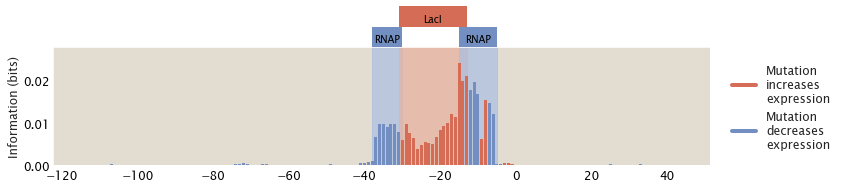

In [11]:
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site) - 10):(len(rnap_site) - 10)]
rep_emat = generate_emap(rep_site, fixed=True, fixed_value=1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
plot_footprint(df, promoter.find(rep_site) - 115)